
# Leave-one-out analysis




In [1]:
# Let's start by importing everything we need.
import os
# To not have numpy start parallelizing on its own
os.environ["OMP_NUM_THREADS"] = "1"

# You may need to set the input data path so that pRT knows where the opacities are stored.
#os.environ["pRT_input_data_path"] = "/u/nnas/packages/petitRADTRANS/petitRADTRANS/input_data/"
os.environ["pRT_input_data_path"] = "/home/sam/Documents/PhD/CRIRES_data_reduction/pRT_data/input_data"

import numpy as np
import matplotlib.pyplot as plt

from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

# Import the class used to set up the retrieval.
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
# Import Prior functions, if necessary.
from petitRADTRANS.retrieval.util import gaussian_prior
# Import an atmospheric model function
from petitRADTRANS.retrieval.models import isothermal_transmission

In [2]:
from petitRADTRANS.physics import isothermal
from petitRADTRANS.retrieval.util import calc_MMW, compute_gravity
# Now we can define the atmospheric model we want to use
def retrieval_model_spec_iso(pRT_object, \
                             parameters, \
                             PT_plot_mode = False,
                             AMR = False):
    """
    retrieval_model_eq_transmission
    This model computes a transmission spectrum based on free retrieval chemistry
    and an isothermal temperature-pressure profile. 
    
    parameters
    -----------
    pRT_object : object
        An instance of the pRT class, with optical properties as defined in the RunDefinition.
    parameters : dict
        Dictionary of required parameters:
            Rstar : Radius of the host star [cm]
            log_g : Log of surface gravity
            R_pl : planet radius [cm]
            Temperature : Isothermal temperature [K]
            species : Log abundances for each species used in the retrieval
            log_Pcloud : optional, cloud base pressure of a grey cloud deck.
    PT_plot_mode : bool
        Return only the pressure-temperature profile for plotting. Evaluate mode only.
    AMR : 
        Adaptive mesh refinement. Use the high resolution pressure grid around the cloud base.

    returns
    -------
    wlen_model : np.array
        Wavlength array of computed model, not binned to data [um]
    spectrum_model : np.array
        Computed transmission spectrum R_pl**2/Rstar**2
    """
    contribution = False
    if "contribution" in parameters.keys():
        contribution = parameters["contribution"].value

    # Make the P-T profile
    pressures = pRT_object.press/1e6 # Convert from bar to cgs; internally pRT uses cgs

    # Note how we access the values of the Parameter class objects
    temperatures = isothermal(pressures,parameters['Temperature'].value)
       
    # If in evaluation mode, and PTs are supposed to be plotted
    if PT_plot_mode:
        return pressures, temperatures
    
    # Make the abundance profiles
    abundances = {}
    msum = 0.0 # Check that the total massfraction of all species is <1
    for species in pRT_object.line_species:
        spec = species.split('_R_')[0] # Dealing with the naming scheme
                                       # for binned down opacities (see below).
        abundances[species] = 10**parameters[spec].value * np.ones_like(pressures)
        msum += 10**parameters[spec].value
    if msum > 1.0:
        return None, None

    abundances['H2'] = 0.766 * (1.0-msum) * np.ones_like(pressures)
    abundances['He'] = 0.234 * (1.0-msum) * np.ones_like(pressures)
    
    # Find the mean molecular weight in each layer
    MMW = calc_MMW(abundances)
    
    gravity, R_pl =  compute_gravity(parameters)
    # Calculate the spectrum
    pRT_object.calc_transm(temperatures,
                           abundances,
                           gravity,
                           MMW,
                           P0_bar=0.01,
                           R_pl = R_pl,
                           Pcloud = 10**parameters['log_Pcloud'].value,
                           contribution = contribution)
                           
    # Transform the outputs into the units of our data.
    wlen_model = nc.c/pRT_object.freq/1e-4 # wlen in micron
    spectrum_model = (pRT_object.transm_rad/parameters['Rstar'].value)**2.
    if contribution:
        return wlen_model, spectrum_model, pRT_object.contr_tr
    return wlen_model, spectrum_model

## Retrieval without H2O

In [3]:
# Lets start out by setting up a simple run definition
# We'll add the data AFTER we define the model function below
# Full details of the parameters can be found in retrieval_config.py

# Since our retrieval has already ran before, we'll set the mode to 'evaluate' so we can make some plots.
RunDefinition = RetrievalConfig(retrieval_name = "hst_example_clear_spec_noH2O", 
                                run_mode = "evaluate", # This must be 'retrieval' to run PyMultiNest     
                                #run_mode = "retrieval", 
                                AMR = False, # We won't be using adaptive mesh refinement for the pressure grid        
                                scattering = False) # This would turn on scattering when calculating emission spectra.
                                                          # Scattering is automatically included for transmission spectra.
    
# Let's start with the parameters that will remain fixed during the retrieval
RunDefinition.add_parameter('Rstar', # name
                             False,   # is_free_parameter, So Rstar is not retrieved here.
                             value = 0.651*nc.r_sun)

# Log of the surface gravity in cgs units.
# The transform_prior_cube argument transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT.
RunDefinition.add_parameter('log_g',
                             True, # is_free_parameter: we are retrieving log(g) here 
                             transform_prior_cube_coordinate = \
                                lambda x : 2.+3.5*x) # This means that log g
                                                                   # can vary between 2 and 5.5
                                  # Note that logg is usually not a free parameter in retrievals of
                                  # transmission spectra, at least it is much better constrained as being
                                  # assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
RunDefinition.add_parameter('R_pl', 
                            True,
                            transform_prior_cube_coordinate = \
                                lambda x : ( 0.2+0.2*x)*nc.r_jup_mean) # Radius varies between 0.2 and 0.4

# Interior temperature in Kelvin
RunDefinition.add_parameter('Temperature', 
                            True,
                            transform_prior_cube_coordinate = \
                                lambda x : 300.+2000.*x)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
RunDefinition.add_parameter("log_Pcloud", 
                            True, 
                            transform_prior_cube_coordinate = \
                                lambda x : -6.0+8.0*x)  # The atmosphere can thus have an opaque cloud
                                                        # between 1e-6 and 100 bar

In [4]:
#RunDefinition.list_available_line_species()
RunDefinition.set_rayleigh_species(['H2', 'He'])
RunDefinition.set_continuum_opacities(['H2-H2', 'H2-He'])

# Here we setup the line species for a free retrieval, setting the prior bounds with the abund_lim parameter
# The retrieved value is the log mass fraction.
# RunDefinition.set_line_species(["CH4", "H2O", "CO2", "CO_all_iso"], free=True, abund_lim = (-6.0,0.0))

# Let's use the most up-to-date line lists
#RunDefinition.set_line_species(["CH4", "H2O_Exomol", "CO2", "CO_all_iso_HITEMP"], eq=False, abund_lim = (-6.0,0.0))
RunDefinition.set_line_species(["CH4", "CO2", "CO_all_iso_HITEMP"], eq=False, abund_lim = (-6.0,0.0))

In [5]:
# Finally, we associate the model with the data, and we can run our retrieval!
import petitRADTRANS # need to get the name for the example data
path_to_data = "" 
path_to_data = petitRADTRANS.__file__.split('__init__.py')[0] # Default location for the example
RunDefinition.add_data('HST',   # Simulated HST data
                       path_to_data + \
                       'retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt', # Where is the data
                       model_generating_function = retrieval_model_spec_iso, # The atmospheric model to use
                       opacity_mode = 'c-k',
                       data_resolution = 60, # The spectral resolution of the data
                       model_resolution = 120) # The resolution of the c-k tables for the lines

# This model is a noise-free, clear atmosphere transmission spectrum for a sub-neptune type planet
# The model function used to calculate it was slightly different, and used different opacity tables
# than what we'll use in the retrieval, but the results don't significantly change.
# In general, it is also useful to use the data_resolution and model_resolution arguments.
# The data_resolution argument will convolve the generated model spectrum by the instrumental 
# resolution prior to calculating the chi squared value.
#
# The model_resolution function uses exo-k to generate low-resolution correlated-k opacity tables
# in order to speed up the radiative transfer calculations. 
# We recommend choosing a model_resolution of about 2x the data_resolution.



In [6]:
##################################################################
# Define what to put into corner plot if run_mode == 'evaluate'
##################################################################
RunDefinition.parameters['R_pl'].plot_in_corner = True
RunDefinition.parameters['R_pl'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
RunDefinition.parameters['R_pl'].corner_transform = lambda x : x/nc.r_jup_mean
RunDefinition.parameters['log_g'].plot_in_corner = True
RunDefinition.parameters['log_g'].corner_ranges = [2., 5.]
RunDefinition.parameters['log_g'].corner_label = "log g"
RunDefinition.parameters['Temperature'].plot_in_corner = True
RunDefinition.parameters['Temperature'].corner_label ="Temp"
RunDefinition.parameters['log_Pcloud'].plot_in_corner = True
RunDefinition.parameters['log_Pcloud'].corner_label =r"log P$_{\rm cloud}$"
RunDefinition.parameters['log_Pcloud'].corner_ranges = [-6, 2]


# Adding all of the chemical species in our atmosphere to the corner plot
for spec in RunDefinition.line_species:
    if 'all_iso' in spec:
        # CO is named CO_all_iso, watch out
        RunDefinition.parameters[spec].corner_label = 'CO'
    RunDefinition.parameters[spec].plot_in_corner = True
    RunDefinition.parameters[spec].corner_ranges = [-6.2,0.2]

    # Note, the post_equal_weights file has the actual abundances.
    # If the retrieval is rerun, it will contain the log10(abundances)
    #RunDefinition.parameters[spec].corner_transform = lambda x : np.log10(x)

##################################################################
# Define axis properties of spectral plot if run_mode == 'evaluate'
##################################################################
RunDefinition.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
RunDefinition.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
RunDefinition.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
RunDefinition.plot_kwargs["xscale"] = 'linear'
RunDefinition.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
RunDefinition.plot_kwargs["nsample"] = 10

##################################################################
# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
##################################################################
RunDefinition.plot_kwargs["take_PTs_from"] = 'HST' 
RunDefinition.plot_kwargs["temp_limits"] = [150, 3000]
RunDefinition.plot_kwargs["press_limits"] = [1e1, 1e-6]

# If in doubt, define all of the plot_kwargs used here.

In [7]:
# If you want to run the retrieval, you need to choose a different output directory name,
# due to pRT requirements.
output_dir = f"{path_to_data}retrieval/examples/transmission/"

retrieval = Retrieval(RunDefinition,
                      output_dir=output_dir,
                      use_MPI = False,        # Run locally, don't need to use MPI for massive parallelisation   
                      sample_spec=False,      # Output the spectrum from nsample random samples.                     
                      pRT_plot_style=True,    # We think that our plots look nice.
                      ultranest=False)        # Let's use pyMultiNest rather than Ultranest
                      
retrieval.run(n_live_points=400,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True)                # Continue retrieval from where it left off.)

# These are dictionaries in case we want to look at multiple retrievals.
# The keys for the dictionaries are the retrieval_names
sample_dict, parameter_dict = retrieval.get_samples()

# Pick the current retrieval to look at. 
samples_use = sample_dict[retrieval.retrieval_name]
parameters_read = parameter_dict[retrieval.retrieval_name]

# Compute the log-likelihoods per sample, per datapoint
#retrieval.get_log_likelihood_per_datapoint(samples_use)

Starting retrieval hst_example_clear_spec_noH2O
Setting up PRT Objects


/home/sam/Documents/pRT_workshop/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CH4_R_120...
 Done.
  Read line opacities of CO2_R_120...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_120...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit likelihood = 168.64
Best fit 𝛘^2 = 8.71
Best fit 𝛘^2/n_wlen = 0.44
Best fit 𝛘^2 = 8.71
Best fit 𝛘^2/DoF = 0.67
No errors detected in the model function!
  analysing data from /home/sam/Documents/pRT_workshop/petitRADTRANS/petitRADTRANS/retrieval/examples/transmission/out_PMN/hst_example_clear_spec_noH2O_.txt
Best fit likelihood = 168.64
Best fit 𝛘^2 = 8.71
Best fit 𝛘^2/n_wlen = 0.44
Best fit 𝛘^2 = 8.71
Best fit 𝛘^2/DoF = 0.67
  marginal likelihood:
    ln Z = 156.7 +- 0.0
  parameters:
    log_g          2.62 +- 0.11
    R_pl           1603263896 +- 61835778
    Temperature    521 +- 124
    log_Pcloud     0.2 +- 1.1
    CH4            -1.66 +- 0.66
    CO2            -3.0 +- 1.8
    CO_all_iso_HITEMP-3.6 +- 1.6


## Retrieval with H2O

In [8]:
# Lets start out by setting up a simple run definition
# We'll add the data AFTER we define the model function below
# Full details of the parameters can be found in retrieval_config.py

# Since our retrieval has already ran before, we'll set the mode to 'evaluate' so we can make some plots.
RunDefinition = RetrievalConfig(retrieval_name = "hst_example_clear_spec", 
                                run_mode = "evaluate", # This must be 'retrieval' to run PyMultiNest     
                                #run_mode = "retrieval", 
                                AMR = False, # We won't be using adaptive mesh refinement for the pressure grid        
                                scattering = False) # This would turn on scattering when calculating emission spectra.
                                                          # Scattering is automatically included for transmission spectra.
    
# Let's start with the parameters that will remain fixed during the retrieval
RunDefinition.add_parameter('Rstar', # name
                             False,   # is_free_parameter, So Rstar is not retrieved here.
                             value = 0.651*nc.r_sun)

# Log of the surface gravity in cgs units.
# The transform_prior_cube argument transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT.
RunDefinition.add_parameter('log_g',
                             True, # is_free_parameter: we are retrieving log(g) here 
                             transform_prior_cube_coordinate = \
                                lambda x : 2.+3.5*x) # This means that log g
                                                                   # can vary between 2 and 5.5
                                  # Note that logg is usually not a free parameter in retrievals of
                                  # transmission spectra, at least it is much better constrained as being
                                  # assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
RunDefinition.add_parameter('R_pl', 
                            True,
                            transform_prior_cube_coordinate = \
                                lambda x : ( 0.2+0.2*x)*nc.r_jup_mean) # Radius varies between 0.2 and 0.4

# Interior temperature in Kelvin
RunDefinition.add_parameter('Temperature', 
                            True,
                            transform_prior_cube_coordinate = \
                                lambda x : 300.+2000.*x)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
RunDefinition.add_parameter("log_Pcloud", 
                            True, 
                            transform_prior_cube_coordinate = \
                                lambda x : -6.0+8.0*x)  # The atmosphere can thus have an opaque cloud
                                                        # between 1e-6 and 100 bar

In [9]:
#RunDefinition.list_available_line_species()
RunDefinition.set_rayleigh_species(['H2', 'He'])
RunDefinition.set_continuum_opacities(['H2-H2', 'H2-He'])

# Here we setup the line species for a free retrieval, setting the prior bounds with the abund_lim parameter
# The retrieved value is the log mass fraction.
# RunDefinition.set_line_species(["CH4", "H2O", "CO2", "CO_all_iso"], free=True, abund_lim = (-6.0,0.0))

# Let's use the most up-to-date line lists
RunDefinition.set_line_species(["CH4", "H2O_Exomol", "CO2", "CO_all_iso_HITEMP"], eq=False, abund_lim = (-6.0,0.0))
#RunDefinition.set_line_species(["CH4", "CO2", "CO_all_iso_HITEMP"], eq=False, abund_lim = (-6.0,0.0))

In [10]:
# Finally, we associate the model with the data, and we can run our retrieval!
import petitRADTRANS # need to get the name for the example data
path_to_data = "" 
path_to_data = petitRADTRANS.__file__.split('__init__.py')[0] # Default location for the example
RunDefinition.add_data('HST',   # Simulated HST data
                       path_to_data + \
                       'retrieval/examples/transmission/observations/HST/hst_example_clear_spec.txt', # Where is the data
                       model_generating_function = retrieval_model_spec_iso, # The atmospheric model to use
                       opacity_mode = 'c-k',
                       data_resolution = 60, # The spectral resolution of the data
                       model_resolution = 120) # The resolution of the c-k tables for the lines

# This model is a noise-free, clear atmosphere transmission spectrum for a sub-neptune type planet
# The model function used to calculate it was slightly different, and used different opacity tables
# than what we'll use in the retrieval, but the results don't significantly change.
# In general, it is also useful to use the data_resolution and model_resolution arguments.
# The data_resolution argument will convolve the generated model spectrum by the instrumental 
# resolution prior to calculating the chi squared value.
#
# The model_resolution function uses exo-k to generate low-resolution correlated-k opacity tables
# in order to speed up the radiative transfer calculations. 
# We recommend choosing a model_resolution of about 2x the data_resolution.



In [11]:
##################################################################
# Define what to put into corner plot if run_mode == 'evaluate'
##################################################################
RunDefinition.parameters['R_pl'].plot_in_corner = True
RunDefinition.parameters['R_pl'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
RunDefinition.parameters['R_pl'].corner_transform = lambda x : x/nc.r_jup_mean
RunDefinition.parameters['log_g'].plot_in_corner = True
RunDefinition.parameters['log_g'].corner_ranges = [2., 5.]
RunDefinition.parameters['log_g'].corner_label = "log g"
RunDefinition.parameters['Temperature'].plot_in_corner = True
RunDefinition.parameters['Temperature'].corner_label ="Temp"
RunDefinition.parameters['log_Pcloud'].plot_in_corner = True
RunDefinition.parameters['log_Pcloud'].corner_label =r"log P$_{\rm cloud}$"
RunDefinition.parameters['log_Pcloud'].corner_ranges = [-6, 2]


# Adding all of the chemical species in our atmosphere to the corner plot
for spec in RunDefinition.line_species:
    if 'all_iso' in spec:
        # CO is named CO_all_iso, watch out
        RunDefinition.parameters[spec].corner_label = 'CO'
    RunDefinition.parameters[spec].plot_in_corner = True
    RunDefinition.parameters[spec].corner_ranges = [-6.2,0.2]

    # Note, the post_equal_weights file has the actual abundances.
    # If the retrieval is rerun, it will contain the log10(abundances)
    #RunDefinition.parameters[spec].corner_transform = lambda x : np.log10(x)

##################################################################
# Define axis properties of spectral plot if run_mode == 'evaluate'
##################################################################
RunDefinition.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
RunDefinition.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
RunDefinition.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
RunDefinition.plot_kwargs["xscale"] = 'linear'
RunDefinition.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
RunDefinition.plot_kwargs["nsample"] = 10

##################################################################
# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
##################################################################
RunDefinition.plot_kwargs["take_PTs_from"] = 'HST' 
RunDefinition.plot_kwargs["temp_limits"] = [150, 3000]
RunDefinition.plot_kwargs["press_limits"] = [1e1, 1e-6]

# If in doubt, define all of the plot_kwargs used here.

In [12]:
# If you want to run the retrieval, you need to choose a different output directory name,
# due to pRT requirements.
output_dir = f"{path_to_data}retrieval/examples/transmission/"

retrieval = Retrieval(RunDefinition,
                      output_dir=output_dir,
                      use_MPI = False,        # Run locally, don't need to use MPI for massive parallelisation   
                      sample_spec=False,      # Output the spectrum from nsample random samples.                     
                      pRT_plot_style=True,    # We think that our plots look nice.
                      ultranest=False)        # Let's use pyMultiNest rather than Ultranest
                      
retrieval.run(n_live_points=400,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True)                # Continue retrieval from where it left off.)

# These are dictionaries in case we want to look at multiple retrievals.
# The keys for the dictionaries are the retrieval_names
sample_dict, parameter_dict = retrieval.get_samples()

# Pick the current retrieval to look at. 
samples_use = sample_dict[retrieval.retrieval_name]
parameters_read = parameter_dict[retrieval.retrieval_name]

# Compute the log-likelihoods per sample, per datapoint
#retrieval.get_log_likelihood_per_datapoint(samples_use)

Starting retrieval hst_example_clear_spec
Setting up PRT Objects


  Read line opacities of CH4_R_120...
 Done.
  Read line opacities of H2O_Exomol_R_120...
 Done.
  Read line opacities of CO2_R_120...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_120...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit likelihood = 172.62
Best fit 𝛘^2 = 0.75
Best fit 𝛘^2/n_wlen = 0.04
Best fit 𝛘^2 = 0.75
Best fit 𝛘^2/DoF = 0.06
No errors detected in the model function!
  analysing data from /home/sam/Documents/pRT_workshop/petitRADTRANS/petitRADTRANS/retrieval/examples/transmission/out_PMN/hst_example_clear_spec_.txt
Best fit likelihood = 172.62
Best fit 𝛘^2 = 0.75
Best fit 𝛘^2/n_wlen = 0.04
Best fit 𝛘^2 = 0.75
Best fit 𝛘^2/DoF = 0.06
  marginal likelihood:
    ln Z = 159.4 +- 0.1
  parameters:
    log_g          2.685 +- 0.097
    R_pl           1608627572 +- 66486542
    Temperature    690 +- 166
    log_Pcloud     0.3 +- 1.1
    CH4            -2.25 +- 0.66
    H2O_Exomol     -2.08 +- 0.80
    CO2            -3.6 +- 

## Compute the ELPDs and plot

In [13]:
elpd_tot, elpd, pareto_k, delta_elpd = retrieval.get_elpd_per_datapoint(
    ret_name=[retrieval.retrieval_name,'hst_example_clear_spec_noH2O']
    )


Plotting Best-fit spectrum
Best fit likelihood = 172.62
  Read line opacities of CH4...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of CO_all_iso_HITEMP...

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit 𝛘^2/DoF = 0.05


/home/sam/Documents/pRT_workshop/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:2372: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


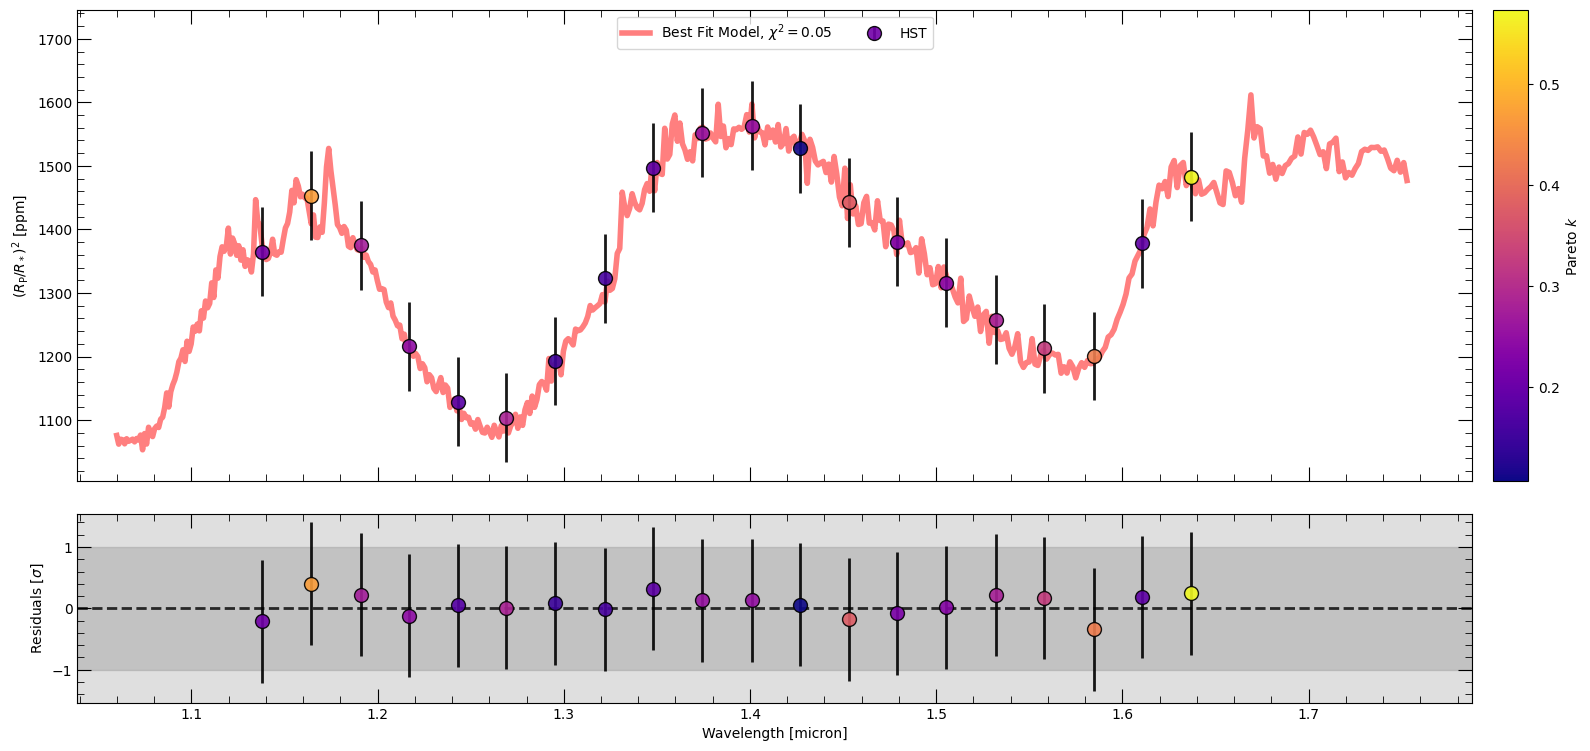


Plotting Best-fit spectrum
Best fit likelihood = 172.62


/home/sam/Documents/pRT_workshop/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CH4...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of CO_all_iso_HITEMP...

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Best fit 𝛘^2/DoF = 0.05


/home/sam/Documents/pRT_workshop/petitRADTRANS/petitRADTRANS/retrieval/retrieval.py:2372: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


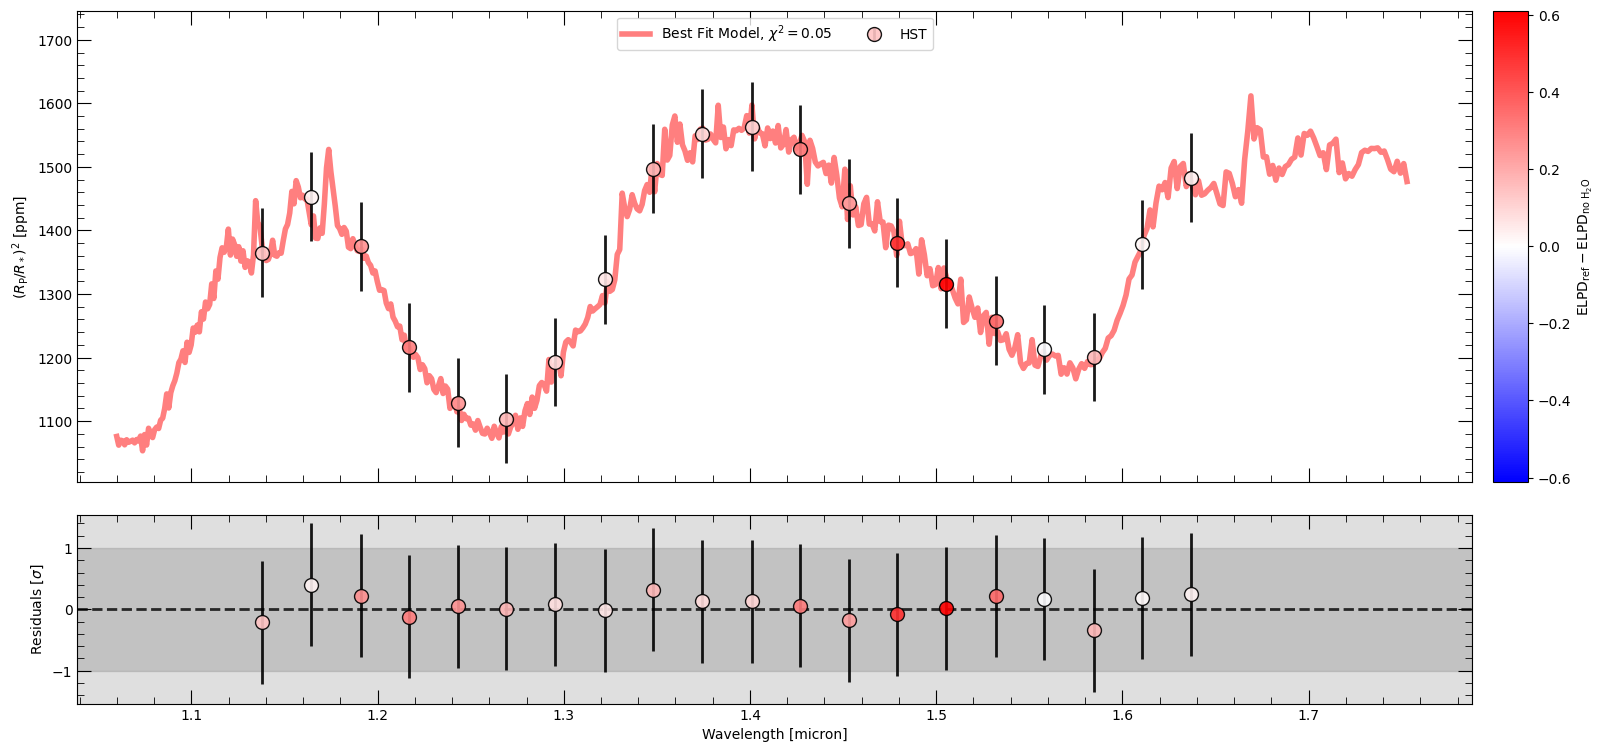

In [14]:
# Plotting the best fit spectrum
# This will generate a few warnings, but it's fine.

fig,ax,ax_r = retrieval.plot_spectra(
    samples_use, parameters_read, refresh = True, mode = 'bestfit', 
    marker_color_type='pareto_k', marker_cmap=plt.cm.plasma, 
    marker_label=r'Pareto $k$'
    )
plt.show()

fig,ax,ax_r = retrieval.plot_spectra(
    samples_use, parameters_read, refresh = True, mode = 'bestfit', 
    marker_color_type='delta_elpd', marker_cmap=plt.cm.bwr, 
    marker_label=r'$\mathrm{ELPD}_\mathrm{ref} - \mathrm{ELPD}_\mathrm{no\ H_2O}$'
    )
plt.show()